In [50]:
import re
import random
import pandas as pd
import hashlib

In [51]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.75) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [52]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Logging in Python,110.918794,4.436752,25
SharePoint,622.045153,36.590891,17
Azure AI Search,735.753476,52.553820,14
Finance Junk,965.444097,160.907349,6
Azure Functions + PP365,1040.132497,22.130479,47
Lost in a Good Book,1090.305738,54.515287,20
Taxes,1198.608622,119.860862,10
Network Mapping,1418.391895,67.542471,21
PP365,1688.245603,168.824560,10
Search Engine Optimization,1943.424751,121.464047,16


# Histogram

53927.33


<Axes: >

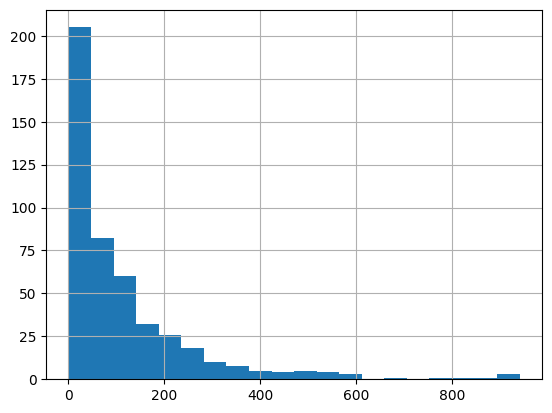

In [53]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [54]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

In [55]:
65e3/1000*40/60

43.333333333333336

# Age Sort

In [56]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [57]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [58]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [59]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [60]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [61]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [62]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [63]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [64]:
n = 6
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 469


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
16,Azure Functions,Durable Functions allows you to define statefu...,3240de336fc685d6d8fddd8ac482fabd,-939.864321,192.765305,-939.864321,3084.244880,0.408242,0,0
18,Azure Functions,2. Which of the following best describes the r...,a0d590c3ccb5acb4ac074724839b549d,-568.236040,192.765305,-939.864321,3084.244880,0.408242,1,0
21,Azure Functions,Managed identities for Azure resources is the ...,d618a61eb92103d74592fcb5b08e7479,-336.082943,192.765305,-939.864321,3084.244880,0.408242,2,0
90,Azure Functions,Activity functions are the basic units of work...,64379cd90c412b46bfd075ad3219f0fe,-227.847384,192.765305,-939.864321,3084.244880,0.408242,3,0
93,Azure Functions,Fan out/fan in: This pattern runs multiple fun...,27d702948647d6ee02788bbddca6e1e1,-177.097294,192.765305,-939.864321,3084.244880,0.408242,4,0
94,Azure Functions,2. Suppose your Azure Function has a blob trig...,9d7bf60762cf8edfb888d6f7aaf00b31,-172.969663,192.765305,-939.864321,3084.244880,0.408242,5,0
31,Home Network Project,Front: What is Fail2Ban and how does it protec...,d7fc83e3380f6d95ec44141a17d86066,-925.285536,231.088613,-925.285536,4390.683649,0.813286,0,0
32,Home Network Project,Front: What is Rate Limiting and how does it h...,8178df4fba6be87bebbac33e10e32135,-919.969895,231.088613,-925.285536,4390.683649,0.813286,1,0
34,Home Network Project,Front: What is Snort and how is it used in net...,683e252e6cd1d5d4c6a922595ea870c2,-543.501890,231.088613,-925.285536,4390.683649,0.813286,2,0
103,Home Network Project,Front: How does Pi-hole utilize DNS Sinkholing...,cd76cc64a6d457c85a16492c91520a16,-403.373216,231.088613,-925.285536,4390.683649,0.813286,3,0


## Age Mean

In [65]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Card Count

In [66]:
# n=3
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



In [67]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
16,Azure Functions,Durable Functions allows you to define statefu...,3240de336fc685d6d8fddd8ac482fabd,-939.864321,192.765305,-939.864321,3084.244880,0.408242,0,0
18,Azure Functions,2. Which of the following best describes the r...,a0d590c3ccb5acb4ac074724839b549d,-568.236040,192.765305,-939.864321,3084.244880,0.408242,1,0
21,Azure Functions,Managed identities for Azure resources is the ...,d618a61eb92103d74592fcb5b08e7479,-336.082943,192.765305,-939.864321,3084.244880,0.408242,2,0
90,Azure Functions,Activity functions are the basic units of work...,64379cd90c412b46bfd075ad3219f0fe,-227.847384,192.765305,-939.864321,3084.244880,0.408242,3,0
93,Azure Functions,Fan out/fan in: This pattern runs multiple fun...,27d702948647d6ee02788bbddca6e1e1,-177.097294,192.765305,-939.864321,3084.244880,0.408242,4,0
94,Azure Functions,2. Suppose your Azure Function has a blob trig...,9d7bf60762cf8edfb888d6f7aaf00b31,-172.969663,192.765305,-939.864321,3084.244880,0.408242,5,0
31,Home Network Project,Front: What is Fail2Ban and how does it protec...,d7fc83e3380f6d95ec44141a17d86066,-925.285536,231.088613,-925.285536,4390.683649,0.813286,0,0
32,Home Network Project,Front: What is Rate Limiting and how does it h...,8178df4fba6be87bebbac33e10e32135,-919.969895,231.088613,-925.285536,4390.683649,0.813286,1,0
34,Home Network Project,Front: What is Snort and how is it used in net...,683e252e6cd1d5d4c6a922595ea870c2,-543.501890,231.088613,-925.285536,4390.683649,0.813286,2,0
103,Home Network Project,Front: How does Pi-hole utilize DNS Sinkholing...,cd76cc64a6d457c85a16492c91520a16,-403.373216,231.088613,-925.285536,4390.683649,0.813286,3,0


In [68]:
existing_cards.head(10)['age'].sum()

-5214.228181190155